# Importación de librerías

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm

from surprise import KNNBasic, accuracy, Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import jaccard_score

## Carga de la información

Cargar la información a partir de los datos proporcionados en Last.fm

In [3]:
users = pd.read_csv('dataset/userid-profile.tsv', sep='\t')
users['age'] = users['age'].fillna(0)

In [32]:
users

,#id,gender,age,country,registered
0,user_000001,m,0.0,Japan,"Aug 13, 2006"
1,user_000002,f,0.0,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,0.0,NaN,"Apr 26, 2006"
4,user_000005,m,0.0,Bulgaria,"Jun 29, 2006"
...,...,...,...,...,...
987,user_000996,f,0.0,United States,"Jul 17, 2006"
988,user_000997,m,0.0,United States,"Jan 5, 2007"
989,user_000998,m,0.0,United Kingdom,"Sep 28, 2005"
990,user_000999,f,0.0,Poland,"Jul 24, 2007"


In [4]:
data_cols = ['user_id', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name']
songs = pd.read_csv('dataset/userid-timestamp-artid-artname-traid-traname.tsv', sep='\t', on_bad_lines='skip', \
                   names = data_cols)

## Preprocesamiento

Se tomó la cantidad de veces que el usuario ha escuchado la canción como su rating. Asimismo, se tomo que si el usuario ha escuchado menos de dos veces la canción, no le gustó y si la ha escuchado mas de dos veces es porque si le gustó.

Del mismo modo, se van a realizar pruebas para recomendación de canciones y artistas.

### Creación de IDs para canciones y artistas

In [5]:
songs_id = pd.DataFrame(songs['track_name'].unique(), columns = ['track_name'])
songs_id['track_id'] = range(1, len(songs_id)+1)

In [6]:
artists_id = pd.DataFrame(songs['artist_name'].unique(), columns = ['artist_name'])
artists_id['artist_id'] = range(1, len(artists_id)+1)

### Unificación de los artistas y canciones y sus respectivos IDs

Se crea una matriz unificada de usuarios, canciones y artistas, junto con sus respectivos IDs.

In [7]:
songs = songs[['user_id', 'artist_name', 'track_name']]
songs = songs.merge(artists_id, on='artist_name', how='left')
songs = songs.merge(songs_id, on='track_name', how='left')
songs = songs[['user_id', 'artist_id', 'artist_name', 'track_id', 'track_name']]

In [8]:
def generate_intervals(dataframe, intervals):
    """
    Función para discretizar los valores de frecuencia de interacción del usuario con las diferentes canciones.
    """
    for interval in intervals:
        min_i = intervals[interval]['min']
        max_i = intervals[interval]['max']
        valor_i = intervals[interval]['valor']
        if max_i != None:
            dataframe.loc[(dataframe['rating']>=min_i) & (dataframe['rating']<max_i), 'rating'] = valor_i
        else:
            dataframe.loc[dataframe['rating']>=min_i, 'rating'] = valor_i
    return dataframe

Intervalos escogidos para 

In [9]:
intervals = {
    'intervalo 1': {'min':0, 'max':10, 'valor':0},
    'intervalo 2': {'min':10, 'max':None, 'valor':1}
}

# Sistema de recomendacion item-item

## Recomendación de canciones

In [10]:
ratings_songs = songs[['user_id', 'track_id']].value_counts().to_frame().reset_index()
ratings_songs.columns = ['user_id', 'track_id', 'rating']
ratings_songs = generate_intervals(ratings_songs, intervals)

Se escogen las n_samples canciones aleatorias para cada usuario.

In [11]:
n_samples = 80
ratings_songs = ratings_songs.groupby('user_id').sample(n=n_samples, random_state=1, replace=True).drop_duplicates()

In [12]:
min_rating, max_rating = ratings_songs['rating'].min(), ratings_songs['rating'].max()

In [13]:
reader = Reader(rating_scale=(min_rating, max_rating))
ratings_songs_dataset = Dataset.load_from_df(ratings_songs[['user_id', 'track_id', 'rating']], reader)

In [14]:
train_set, test_set=  train_test_split(ratings_songs_dataset, test_size=0.2)

In [17]:
similarities = ['cosine', 'pearson', 'msd']
KS = [50, 20, 10, 5]
data_songs = []
for similarity in similarities:
    sim_options = {'name': similarity,
                   'user_based': False
                   }
    bsl_options = {'n_epochs': 20}    
    for K in KS:
        print('Running for similarity: {} and K: {}'.format(similarity, K))
        model = KNNBasic(k=K, min_k=2, sim_options=sim_options, bsl_options=bsl_options)
        
        model.fit(trainset=train_set)
        predictions = model.test(test_set)
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        data_row = ['Recomendacion por canciones', n_samples, similarity, K, rmse, mae]
        data_songs.append(data_row)

data_songs_df = pd.DataFrame(data=data_songs, columns=['TIPO_RECOMENDACION', 'CANTIDAD_CANCIONES', 'SIMILITUD', 'K',\
                                                       'RMSE', 'MAE'])

Running for similarity: cosine and K: 50
Computing the cosine similarity matrix...


C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
RMSE: 0.4996
MAE:  0.4991
Running for similarity: cosine and K: 20
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4996
MAE:  0.4991
Running for similarity: cosine and K: 10
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4996
MAE:  0.4991
Running for similarity: cosine and K: 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4996
MAE:  0.4992
Running for similarity: pearson and K: 50
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4998
MAE:  0.4997
Running for similarity: pearson and K: 20
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4998
MAE:  0.4997
Running for similarity: pearson and K: 10
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4998
MAE:  0.4997
Running for similarity: pearson and K: 5
Computing the pearson similarity mat

In [18]:
data_songs_df.to_csv('stats_songs_item_item.csv', sep='|', decimal=',', index=False)

## Recomendación por artistas

In [15]:
ratings_artists = songs[['user_id', 'artist_id']].value_counts().to_frame().reset_index()
ratings_artists.columns = ['user_id', 'artist_id', 'rating']
ratings_artists = generate_intervals(ratings_artists, intervals)

Se escogen los n_samples artistas aleatorias para cada usuario.

In [16]:
n_samples = 80
ratings_artists = ratings_artists.groupby('user_id').sample(n=n_samples, random_state=1, replace=True).drop_duplicates()

In [17]:
min_rating, max_rating = ratings_artists['rating'].min(), ratings_artists['rating'].max()

In [18]:
reader = Reader(rating_scale=(min_rating, max_rating))
ratings_artists_dataset = Dataset.load_from_df(ratings_artists[['user_id', 'artist_id', 'rating']], reader)

In [19]:
train_set, test_set=  train_test_split(ratings_artists_dataset, test_size=0.2)

In [20]:
similarities = ['cosine', 'pearson', 'msd']
KS = [50, 20, 10, 5]
data_artists = []
for similarity in similarities:
    sim_options = {'name': similarity,
                   'user_based': False
                   }
    bsl_options = {'n_epochs': 20}
    for K in KS:
        print('Running for similarity: {} and K: {}'.format(similarity, K))
        model = KNNBasic(k=K, min_k=2, sim_options=sim_options, bsl_options=bsl_options)
        
        model.fit(trainset=train_set)
        predictions = model.test(test_set)
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        data_row = ['Recomendacion por artistas', n_samples, similarity, K, rmse, mae]
        data_artists.append(data_row)

data_artists_df = pd.DataFrame(data=data_artists, columns=['TIPO_RECOMENDACION', 'CANTIDAD_ARTISTAS', 'SIMILITUD', 'K', \
                                                           'RMSE', 'MAE'])

Running for similarity: cosine and K: 50
Computing the cosine similarity matrix...


C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
RMSE: 0.4488
MAE:  0.3886
Running for similarity: cosine and K: 20
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4503
MAE:  0.3904
Running for similarity: cosine and K: 10
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4504
MAE:  0.3901
Running for similarity: cosine and K: 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4531
MAE:  0.3916
Running for similarity: pearson and K: 50
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4509
MAE:  0.3965
Running for similarity: pearson and K: 20
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4509
MAE:  0.3965
Running for similarity: pearson and K: 10
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4509
MAE:  0.3965
Running for similarity: pearson and K: 5
Computing the pearson similarity mat

In [25]:
data_artists_df.to_csv('stats_artists_item_item.csv', sep='|', decimal=',', index=False)

In [22]:
data_artists_df.sort_values(by='RMSE')

,TIPO_RECOMENDACION,CANTIDAD_ARTISTAS,SIMILITUD,K,RMSE,MAE
0,Recomendacion por artistas,80,cosine,50,0.448826,0.388650
1,Recomendacion por artistas,80,cosine,20,0.450285,0.390373
2,Recomendacion por artistas,80,cosine,10,0.450414,0.390146
8,Recomendacion por artistas,80,msd,50,0.450624,0.382558
9,Recomendacion por artistas,80,msd,20,0.450730,0.382599
4,Recomendacion por artistas,80,pearson,50,0.450942,0.396525
5,Recomendacion por artistas,80,pearson,20,0.450942,0.396525
6,Recomendacion por artistas,80,pearson,10,0.450949,0.396532
7,Recomendacion por artistas,80,pearson,5,0.451167,0.396556
10,Recomendacion por artistas,80,msd,10,0.452002,0.382465


# Sistema de recomendacion user-user

## Recomendación de canciones

In [26]:
ratings_songs = songs[['user_id', 'track_id']].value_counts().to_frame().reset_index()
ratings_songs.columns = ['user_id', 'track_id', 'rating']
ratings_songs = generate_intervals(ratings_songs, intervals)

Se escogen las n_samples canciones aleatorias para cada usuario.

In [27]:
n_samples = 80
ratings_songs = ratings_songs.groupby('user_id').sample(n=n_samples, random_state=1, replace=True).drop_duplicates()

In [28]:
min_rating, max_rating = ratings_songs['rating'].min(), ratings_songs['rating'].max()

In [29]:
reader = Reader(rating_scale=(min_rating, max_rating))
ratings_songs_dataset = Dataset.load_from_df(ratings_songs[['user_id', 'track_id', 'rating']], reader)

In [30]:
train_set, test_set=  train_test_split(ratings_songs_dataset, test_size=0.2)

In [31]:
similarities = ['cosine', 'pearson', 'msd']
KS = [50, 20, 10, 5]
data_songs = []
for similarity in similarities:
    sim_options = {'name': similarity,
                   'user_based': True
                   }
    bsl_options = {'n_epochs': 20}    
    for K in KS:
        print('Running for similarity: {} and K: {}'.format(similarity, K))
        model = KNNBasic(k=K, min_k=2, sim_options=sim_options, bsl_options=bsl_options)
        
        model.fit(trainset=train_set)
        predictions = model.test(test_set)
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        data_row = ['Recomendacion por canciones', n_samples, similarity, K, rmse, mae]
        data_songs.append(data_row)

data_songs_df = pd.DataFrame(data=data_songs, columns=['TIPO_RECOMENDACION', 'CANTIDAD_CANCIONES', 'SIMILITUD', 'K', \
                                                       'RMSE', 'MAE'])

Running for similarity: cosine and K: 50
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4999
MAE:  0.4996
Running for similarity: cosine and K: 20
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4999
MAE:  0.4996
Running for similarity: cosine and K: 10
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4999
MAE:  0.4996
Running for similarity: cosine and K: 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4999
MAE:  0.4997
Running for similarity: pearson and K: 50
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4999
MAE:  0.4997
Running for similarity: pearson and K: 20
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4999
MAE:  0.4997
Running for similarity: pearson and K: 10
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4999
MAE:  0

In [32]:
data_songs_df.to_csv('stats_songs_user_user.csv', sep='|', decimal=',', index=False)

## Recomendación por artistas

In [23]:
ratings_artists = songs[['user_id', 'artist_id']].value_counts().to_frame().reset_index()
ratings_artists.columns = ['user_id', 'artist_id', 'rating']
ratings_artists = generate_intervals(ratings_artists, intervals)

Se escogen los n_samples artistas aleatorias para cada usuario.

In [24]:
n_samples = 80
ratings_artists = ratings_artists.groupby('user_id').sample(n=n_samples, random_state=1, replace=True).drop_duplicates()

In [25]:
min_rating, max_rating = ratings_artists['rating'].min(), ratings_artists['rating'].max()

In [26]:
reader = Reader(rating_scale=(min_rating, max_rating))
ratings_artists_dataset = Dataset.load_from_df(ratings_artists[['user_id', 'artist_id', 'rating']], reader)

In [27]:
train_set, test_set=  train_test_split(ratings_artists_dataset, test_size=0.2)

In [28]:
similarities = ['cosine', 'pearson', 'msd']
KS = [50, 20, 10, 5]
data_artists = []
for similarity in similarities:
    sim_options = {'name': similarity,
                   'user_based': True
                   }
    bsl_options = {'n_epochs': 20}
    for K in KS:
        print('Running for similarity: {} and K: {}'.format(similarity, K))
        model = KNNBasic(k=K, min_k=2, sim_options=sim_options, bsl_options=bsl_options)
        
        model.fit(trainset=train_set)
        predictions = model.test(test_set)
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        data_row = ['Recomendacion por artistas', n_samples, similarity, K, rmse, mae]
        data_artists.append(data_row)

data_artists_df = pd.DataFrame(data=data_artists, columns=['TIPO_RECOMENDACION', 'CANTIDAD_ARTISTAS', 'SIMILITUD', \
                                                           'K', 'RMSE', 'MAE'])

Running for similarity: cosine and K: 50
Computing the cosine similarity matrix...


C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
RMSE: 0.4555
MAE:  0.4003
Running for similarity: cosine and K: 20
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4567
MAE:  0.4005
Running for similarity: cosine and K: 10
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4561
MAE:  0.3997
Running for similarity: cosine and K: 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4562
MAE:  0.3999
Running for similarity: pearson and K: 50
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4526
MAE:  0.4023
Running for similarity: pearson and K: 20
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4526
MAE:  0.4023
Running for similarity: pearson and K: 10
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4526
MAE:  0.4023
Running for similarity: pearson and K: 5
Computing the pearson similarity mat

In [39]:
data_artists_df.to_csv('stats_artists_user_user.csv', sep='|', decimal=',', index=False)

## Best Model

In [29]:
sim_options = {'name': 'cosine',
               'user_based': True
               }
bsl_options = {'n_epochs': 50}    
K = 50

model = KNNBasic(k=K, min_k=2, sim_options=sim_options, bsl_options=bsl_options)

model.fit(trainset=train_set)
predictions = model.test(test_set)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# Save to file in the current working directory
pkl_filename = "best_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4555
MAE:  0.4003


## Generacion de graficas

In [138]:
stast = pd.read_excel('stats_def.xlsx')

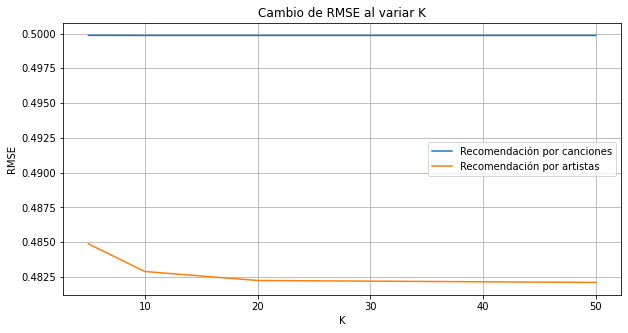

In [137]:
canciones = stast[stast['TIPO_RECOMENDACION']=='Recomendacion por canciones'][['K', 'RMSE']].groupby('K').mean()
artistas = stast[stast['TIPO_RECOMENDACION']=='Recomendacion por artistas'][['K', 'RMSE']].groupby('K').mean()

plt.figure(figsize=(10,5))
plt.plot(canciones)
plt.plot(artistas)
plt.title('Cambio de RMSE al variar K')
plt.legend(['Recomendación por canciones', 'Recomendación por artistas'])
plt.xlabel('K')
plt.ylabel('RMSE')
plt.grid()

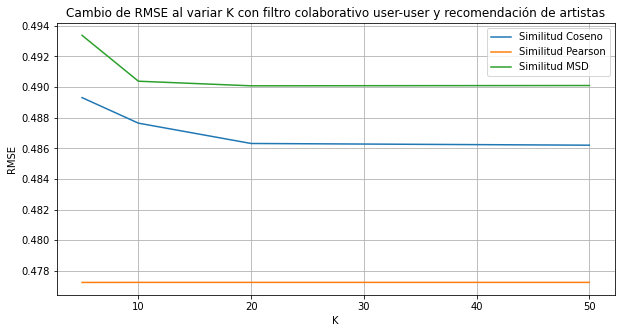

In [135]:
canciones = stast[stast['TIPO_RECOMENDACION']=='Recomendacion por artistas']
user = canciones[canciones['FILTRO_COLABORATIVO']=='user-user']
user_cosine = user[user['SIMILITUD']=='cosine'][['K', 'RMSE']].groupby('K').mean()
user_pearson = user[user['SIMILITUD']=='pearson'][['K', 'RMSE']].groupby('K').mean()
user_msd = user[user['SIMILITUD']=='msd'][['K', 'RMSE']].groupby('K').mean()

plt.figure(figsize=(10,5))
plt.plot(user_cosine)
plt.plot(user_pearson)
plt.plot(user_msd)
plt.title('Cambio de RMSE al variar K con filtro colaborativo user-user y recomendación de artistas')
plt.legend(['Similitud Coseno', 'Similitud Pearson', 'Similitud MSD'])
plt.xlabel('K')
plt.ylabel('RMSE')
plt.grid()

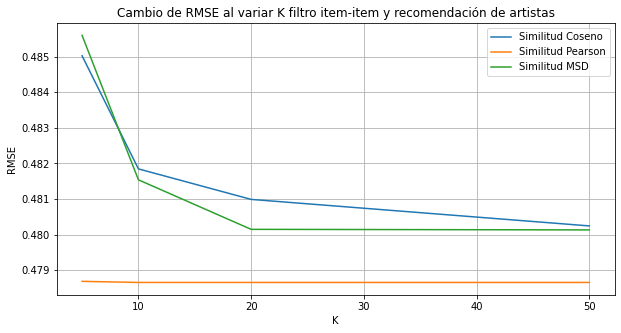

In [136]:
canciones = stast[stast['TIPO_RECOMENDACION']=='Recomendacion por artistas']
item = canciones[canciones['FILTRO_COLABORATIVO']=='item-item']
item_cosine = item[item['SIMILITUD']=='cosine'][['K', 'RMSE']].groupby('K').mean()
item_pearson = item[item['SIMILITUD']=='pearson'][['K', 'RMSE']].groupby('K').mean()
item_msd = item[item['SIMILITUD']=='msd'][['K', 'RMSE']].groupby('K').mean()

plt.figure(figsize=(10,5))
plt.plot(item_cosine)
plt.plot(item_pearson)
plt.plot(item_msd)
plt.title('Cambio de RMSE al variar K filtro item-item y recomendación de artistas')
plt.legend(['Similitud Coseno', 'Similitud Pearson', 'Similitud MSD'])
plt.xlabel('K')
plt.ylabel('RMSE')
plt.grid()